In [109]:
%run Function_set_gurobi.ipynb

import networkx as nx

import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt
import json
import os
from tqdm.notebook import tqdm

In [110]:
from collections import defaultdict

import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import*
from gurobipy import quicksum

In [111]:
def constraint_1(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_matched = []
    
    for vertex_selected in index:
            
        #print(int(compelete_label[(vertex, vertex_selected)]))
        
            index_matched.append( int(compelete_label[(vertex, vertex_selected)]) )
    
    return index_matched

In [112]:
def constraint_2(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index_out = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_out_matched = []
    
    for vertex_selected in index_out:
            
        index_out_matched.append( int(compelete_label[(vertex, vertex_selected)])  )
    
    index_in = np.hstack(np.asarray(np.where(Final_map[:,vertex])))
    
    index_in_matched = []
    
    for vertex_selected in index_in:
        index_in_matched.append( int(compelete_label[(vertex_selected, vertex )])  )

    
    return index_out_matched, index_in_matched

In [152]:
%run Function_set_gurobi.ipynb
def test(network,pos):
    G, compelete_label, graph = complete_Graph(network,pos)
    G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)
    
    # How many panel ---> Max electricity level wire could reach 
    Q = len(pos)-1
    
    # How many edges
    edge_number = len(compelete_label)


    # basic_cost shape => (1,number_of_edge)
    # such as : basic_cost = np.vstack(np.ones(number_of_edge))
    # test case : #basic_cost = np.arange(edge_number)

    basic_cost = np.ones(edge_number) * 2


    # flow cost (p)
    flow_cost = np.ones(edge_number) 
    p = 1


    # make dictionary
    edge_dictionary, Total = make_dictionary(edge_number, Q)

    # initialize a QUBO matrix needed
    QUBO_matrix_initial = np.zeros((Total, Total))
    
    c_e = (np.tile(np.vstack(basic_cost),(1,Q+1)))
        
    level_coeff = (np.tile(np.arange(1,Q + 1),(edge_number,1))).flatten()
    
    
    m_t_u = np.zeros(Q)
    m_t_l = np.zeros(Q)
    #m_t_l[3] = 1
    m_t_l[2] = 1
    m_t_u[:] = 3
    
    
    try:

        # Create a new model
        m = gp.Model("Solar_panel_old_model")
        m.Params.LogToConsole = 0

        # Create variables
        x = m.addVars(edge_number, Q, vtype=GRB.BINARY, name="x")

        #print(x)
        # Set objective
        
        m.setObjective( quicksum(quicksum((p * j) * c_e[i,j]  * x[i,j] for i in range(Q , edge_number)) for j in range(Q))
                       + quicksum(quicksum(c_e[i,j]  * x[i,j] for i in range(edge_number)) for j in range(Q)) , GRB.MAXIMIZE)
    

        # Add constraint 1:
        for vertex in range(1, Q + 1):

            index = constraint_1(network, Q, edge_dictionary, compelete_label, vertex)

            # 
            m.addConstr(quicksum( quicksum(x[i,j] for j in range(Q)) for i in index) == 1, name=f'constraint_1_vertex_{vertex}')

        # Add constraint 2:  
        for vertex in range(1, Q + 1):

            index_out, index_in = constraint_2(network, Q, edge_dictionary, compelete_label, vertex)

            #print(index_out, index_in, level_coeff[index_in])

            m.addConstr( quicksum(quicksum( (j+1) * x[i,j] for j in range(Q)) for i in index_out) - quicksum( quicksum( (n+1) * x[m,n] for n in range(Q)) for m in index_in)  == 1, name=f'constraint_2_vertex_{vertex}')

        # Add constraint 3:
        for level in range(Q):

            m.addConstr( quicksum( x[m,level] for m in range(Q)) <= m_t_u [level], name=f'constraint_3_rhs_{level}')
            m.addConstr( quicksum( x[m,level] for m in range(Q)) >= m_t_l [level], name=f'constraint_3_lhs_{level}')

        # Optimize model
        m.optimize()
        #print (m.display())
        
        time = m.Runtime
        
        print(time)

        x_list = [str.replace(str.replace(v.varName,"]",""),"x[","") for v in m.getVars() if v.x == 1 and v.varName[0] =='x']

        #print('Obj: %g' % m.objVal)
        
        
        print("Gurobi runtime is", m.Runtime ,"seconds")
        
        plt.figure(5)
        final_G = nx.DiGraph()
        final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))
        
        
        support_G = nx.DiGraph()
        support_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

        #print(str(final_index // Q))
        #print(str(final_index % Q))

        for item in x_list:
            #print(item)

            index, level = item.split(',')

            #print(index, int(level) + 1)

            final_G.add_weighted_edges_from([(*edge, int(level)+1)  for edge, label in compelete_label.items() if label == index ])
            support_G.add_weighted_edges_from([(*edge, (int(level)+1) * 2.2 ) for edge, label in compelete_label.items() if label == index] )


        matfig = plt.figure(i,figsize=(10,10)) 
        labels = nx.get_edge_attributes(final_G,'weight')
        widths = list(nx.get_edge_attributes(support_G,'weight').values())
        #print("widths",widths)
        nx.draw_networkx(final_G, pos, node_size = 850, font_size = 16)
        nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels,font_size = 20,label_pos = 0.6)
        nx.draw_networkx_edges(final_G,pos,width = widths)

        #matfig = plt.figure(figsize=(10,10)) 
        #labels = nx.get_edge_attributes(final_G,'weight')
        #widths = list(nx.get_edge_attributes(final_G,'weight').values())
        #print("widths",widths)
        #nx.draw_networkx(final_G, pos)
        #nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
        #nx.draw_networkx_edges(final_G,pos,width = widths)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    
    return time


F:\UoH\UoH_code\Minimum Spanning Tree\Gurobi\W3_H3_Benchmark
0.028524398803710938
Gurobi runtime is 0.028524398803710938 seconds


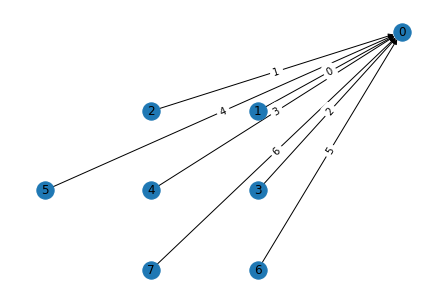

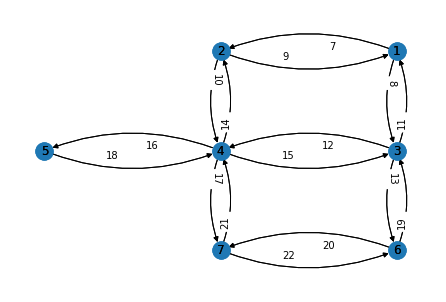

<Figure size 432x288 with 0 Axes>

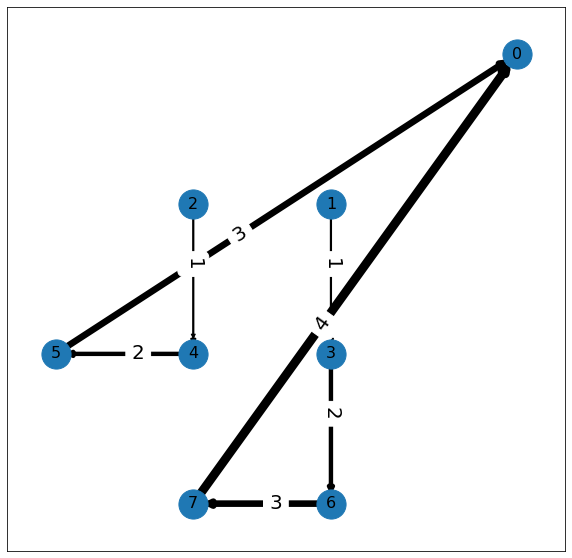

In [153]:
import time

bench_num = 10

Width = 3
Height = 3


current_directory = os.getcwd()
    
next_dir = "W%d_H%d_Benchmark"%(Width, Height)
    
final_directory = os.path.join(current_directory, next_dir)

time_list = np.zeros(bench_num)
    
print(final_directory)
    
if not os.path.exists(final_directory):
    os.makedirs(final_directory)


#for i in tqdm(range(bench_num)):  
#for i in tqdm(range(1)):  
i = 0

network = np.load("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.npy"%(Width, Height, Width, Height, i))
    
with open("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.json"%(Width, Height, Width, Height, i), 'r') as f:
    data = json.load(f)
    pos_convert = json.loads(data)
        
pos = {}
    
for key in pos_convert.keys():
    pos[int(key)] = tuple(pos_convert[key])

    
time_test = test(network,pos)
    
time_list[i] = time_test
      

In [92]:
print(np.mean(time_list))

0.002702140808105469


In [93]:
#time_list

0.027523040771484375
Gurobi runtime is 0.027523040771484375 seconds
widths [1, 1, 2, 2, 3, 3, 4]
0.023019790649414062
Gurobi runtime is 0.023019790649414062 seconds
widths [1, 2, 4, 3, 3, 1, 2]
0.024021148681640625
Gurobi runtime is 0.024021148681640625 seconds
widths [1, 2, 4, 3, 3, 1, 2]
0.05854988098144531
Gurobi runtime is 0.05854988098144531 seconds
widths [3, 2, 4, 3, 1, 2, 1]
0.015012741088867188
Gurobi runtime is 0.015012741088867188 seconds
widths [1, 2, 3, 1, 4, 3, 2]
0.029024124145507812
Gurobi runtime is 0.029024124145507812 seconds
widths [1, 1, 2, 2, 3, 3, 4]
0.029026031494140625
Gurobi runtime is 0.029026031494140625 seconds
widths [1, 1, 2, 2, 3, 3, 4]
0.027021408081054688
Gurobi runtime is 0.027021408081054688 seconds
widths [1, 1, 2, 2, 3, 3, 4]
0.061553955078125
Gurobi runtime is 0.061553955078125 seconds
widths [3, 2, 4, 3, 1, 2, 1]
0.0345306396484375
Gurobi runtime is 0.0345306396484375 seconds
widths [4, 2, 3, 1, 1, 3, 2]

0.03292827606201172


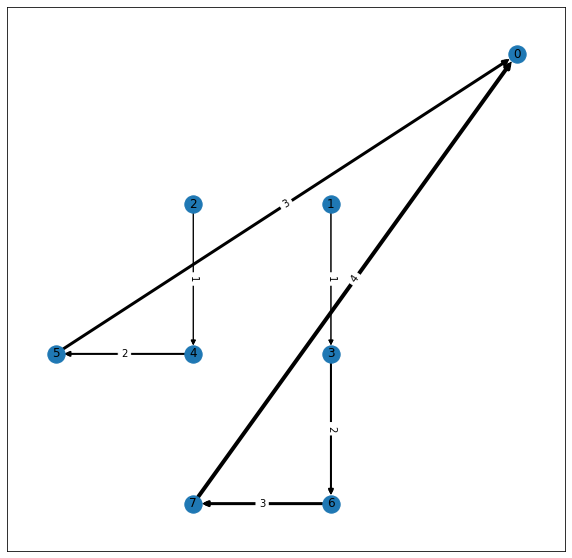

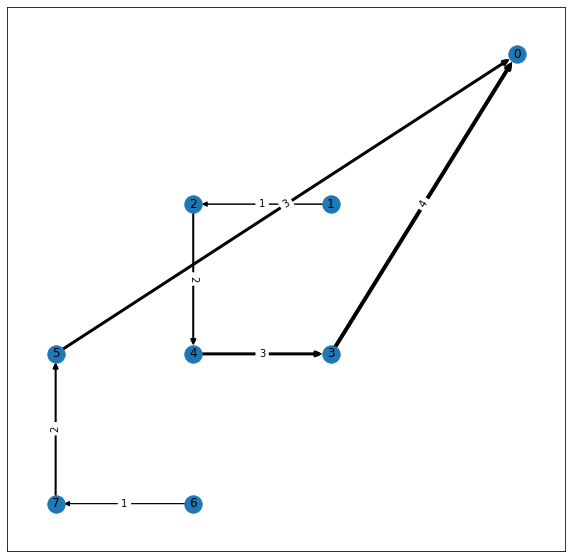

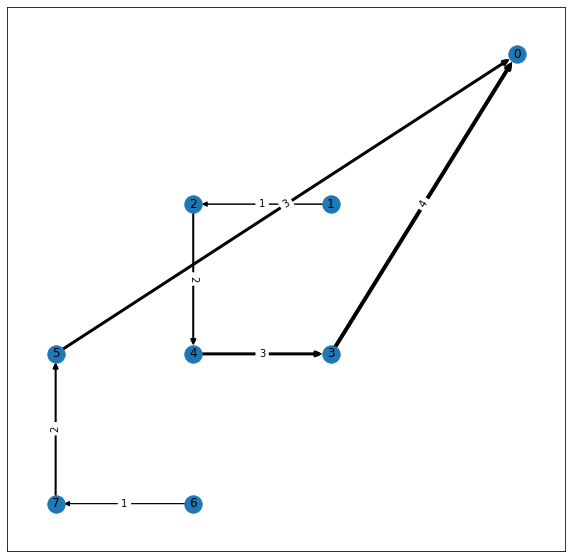

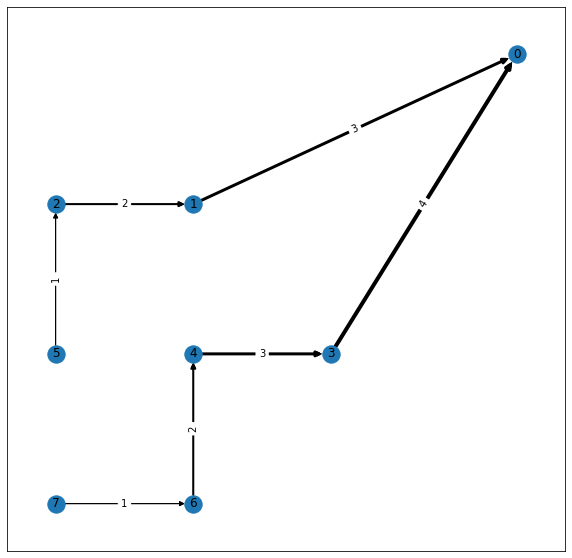

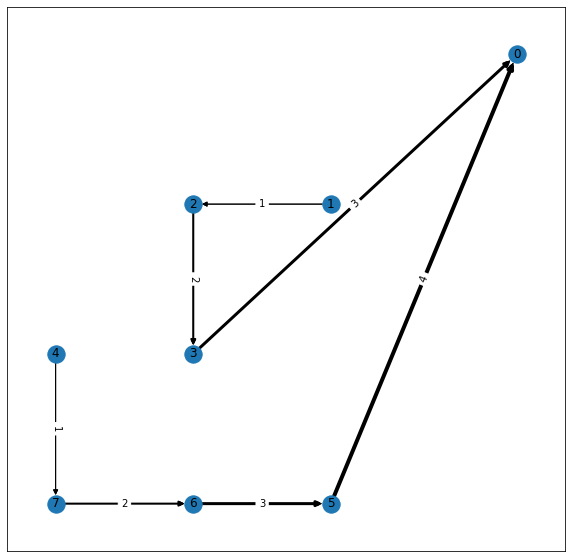

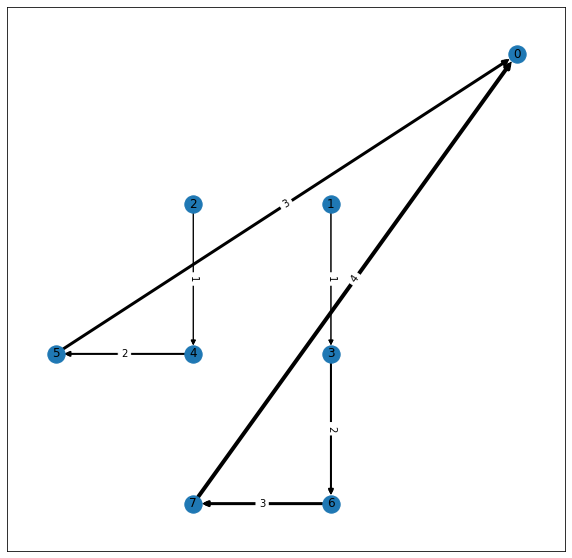

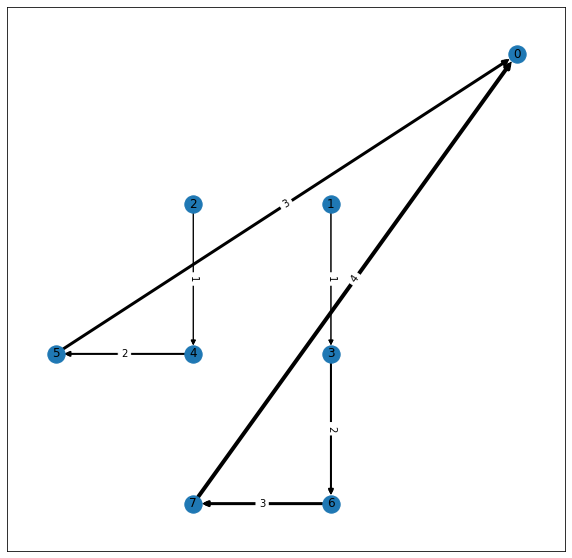

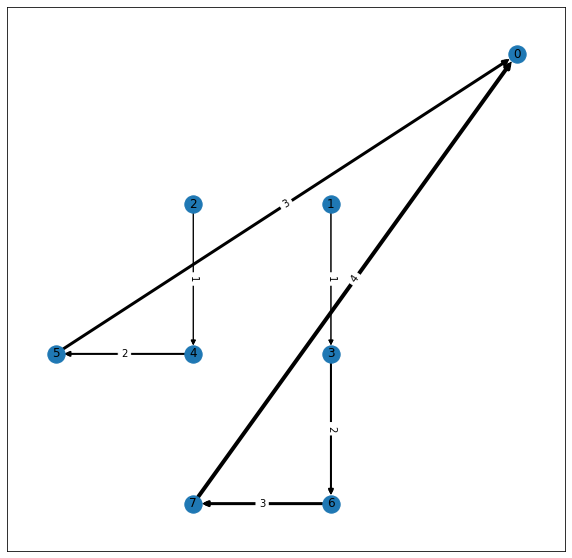

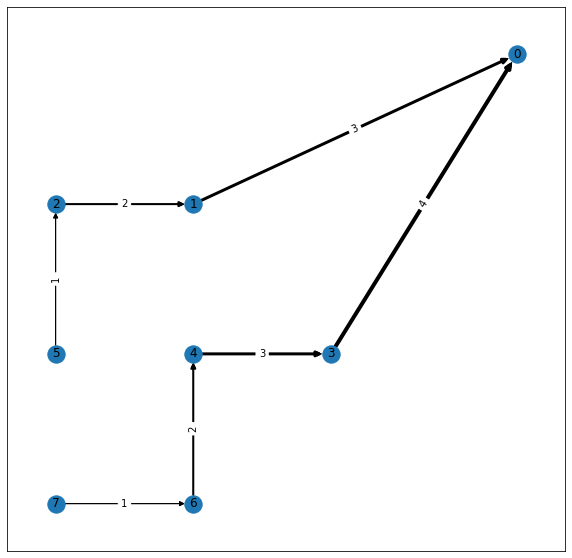

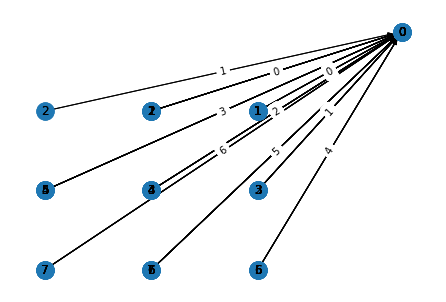

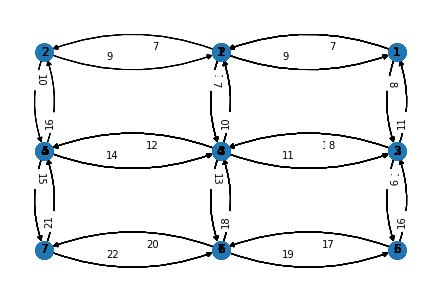

<Figure size 432x288 with 0 Axes>

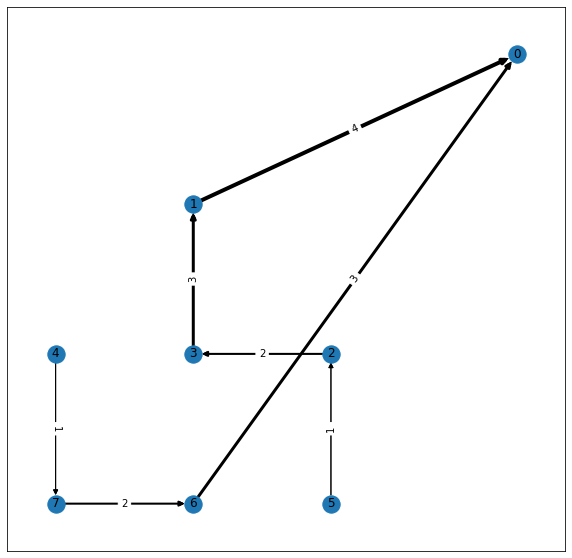

In [106]:
for i in tqdm(range(bench_num)):  
    #for i in tqdm(range(1)):  

    network = np.load("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.npy"%(Width, Height, Width, Height, i))

    with open("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.json"%(Width, Height, Width, Height, i), 'r') as f:
        data = json.load(f)
        pos_convert = json.loads(data)

    pos = {}

    for key in pos_convert.keys():
        pos[int(key)] = tuple(pos_convert[key])


    time_test = test(network,pos)

    time_list[i] = time_test
    
print(np.mean(time_list))

In [102]:
time_list

array([0.0285244 , 0.02252007, 0.02301979, 0.06005096, 0.01651382,
       0.02852631, 0.02902412, 0.02752304, 0.05904961, 0.0340271 ])

In [105]:
time_list

array([0.02602386, 0.02351952, 0.02351761, 0.05905151, 0.01551247,
       0.03002548, 0.02752304, 0.02602196, 0.06105232, 0.0375309 ])

In [107]:
time_list

array([0.02752304, 0.02301979, 0.02402115, 0.05854988, 0.01501274,
       0.02902412, 0.02902603, 0.02702141, 0.06155396, 0.03453064])